In [51]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score
import tensorflow_decision_forests as tfdf
import tensorflow as tf
from numpy.typing import NDArray
import matplotlib.pyplot as plt
import seaborn as sns


In [54]:
def evaluate_model(y_true: NDArray[np.complex64], y_pred: NDArray[np.complex64]):
    pr_auc = average_precision_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)

    print(f"PR AUC: {pr_auc.round(4)}")
    print(f"ROC AUC: {roc_auc.round(4)}")

    return pr_auc, roc_auc


def plot_tfdf_logs(inspector: tfdf.inspector.AbstractInspector):
    # This function is blah blahß
    logs = inspector.training_logs()
    num_trees = [log.num_trees for log in logs]
    losses = [log.evaluation.loss for log in logs]

    plt.plot(num_trees, losses)
    plt.xlabel("Number of Trees")
    plt.ylabel("Validation Loss")
    plt.show()


def plot_tfdf_importances(
    inspector: tfdf.inspector.AbstractInspector, importance_type: str
):
    """Extracts and plots TFDF importances from the given inspector object

    Args:
        inspector (tfdf.inspector.AbstractInspector): inspector object created from your TFDF model
        importance_type (str): importance type to plotß
    """
    try:
        importances = inspector.variable_importances()[importance_type]
    except KeyError:
        raise ValueError(
            f"No {importance_type} importances found in the given inspector object"
        )

    names = []
    scores = []
    for f in importances:
        names.append(f[0].name)
        scores.append(f[1])

    sns.barplot(x=scores, y=names, color="#5a7dbf")
    plt.xlabel(importance_type)
    plt.title("Variable Importance")
    plt.show()

In [9]:
NUMERIC_FEATURES = [
    "Term",
    "NoEmp",
    "CreateJob",
    "RetainedJob",
    "longitude",
    "latitude",
    "GrAppv",
    "SBA_Appv",
    "is_new",
    "same_state",
]

CATEGORICAL_FEATURES = [
    "FranchiseCode",
    "UrbanRural",
    "City",
    "State",
    "Bank",
    "BankState",
    "RevLineCr",
    "naics_first_two",
]

TARGET = "is_default"

## Load Data

In [10]:
train_data: pd.DataFrame = pd.read_parquet("../data/train_data.parquet")
val_data: pd.DataFrame = pd.read_parquet("../data/val_data.parquet")
test_data: pd.DataFrame = pd.read_parquet("../data/test_data.parquet")

In [11]:
train_data.shape

(802301, 20)

## Prepare Data

### Feature Types

In [47]:
dsets = [train_data,val_data,test_data]
for d in dsets:
    d[NUMERIC_FEATURES] = d[NUMERIC_FEATURES].astype(np.float32)
    d[CATEGORICAL_FEATURES] = d[CATEGORICAL_FEATURES].astype(str)

### Specify Feature Usage

In [15]:
feature_usages = []

for feature_name in NUMERIC_FEATURES:
    feature_usage = tfdf.keras.FeatureUsage(
        name=feature_name, semantic=tfdf.keras.FeatureSemantic.NUMERICAL
    )
    feature_usages.append(feature_usage)

for feature_name in CATEGORICAL_FEATURES:
    feature_usage = tfdf.keras.FeatureUsage(
        name=feature_name,
        semantic=tfdf.keras.FeatureSemantic.CATEGORICAL,
        min_vocab_frequency=1000,
    )
    feature_usages.append(feature_usage)

### TF Dataset

In [16]:
# Use TF Dataset
train_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(
    train_data, label=TARGET, weight=None, batch_size=1000
)
val_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(
    val_data, label=TARGET, weight=None, batch_size=1000
)
test_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(
    test_data, label=TARGET, weight=None, batch_size=1000
)

Metal device set to: Apple M2 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-04-02 16:47:37.674549: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-02 16:47:37.674576: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Base Models

### Fit in-memory

In [67]:
# Define the models
gbt_model = tfdf.keras.GradientBoostedTreesModel(
    features=feature_usages,
    exclude_non_specified_features=True,
)

rf_model = tfdf.keras.RandomForestModel(
    features=feature_usages,
    exclude_non_specified_features=True,
)

# Compile the models (Optional)
gbt_model.compile(metrics=[tf.keras.metrics.AUC(curve="PR")])
rf_model.compile(metrics=[tf.keras.metrics.AUC(curve="PR")])

# Fit the models
gbt_model.fit(train_dataset, validation_data=val_dataset)
rf_model.fit(train_dataset, validation_data=val_dataset)


In [68]:
gbt_test_preds_basic = gbt_model.predict(test_dataset)
rf_test_preds_basic = rf_model.predict(test_dataset)

50/58 [========================>.....] - ETA: 0s

2023-04-04 17:48:27.336497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 2/58 [>.............................] - ETA: 3s

2023-04-04 17:48:27.568628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


58/58 [==============================] - 4s 67ms/step


In [73]:
print("GBT with Default Parameters")
default_gbt_pr, default_gbt_roc = evaluate_model(
    test_data[TARGET].values, gbt_test_preds_basic.ravel()
)

print("\nRF with Default Parameters")
default_rf_pr, default_rf_roc = evaluate_model(
    test_data[TARGET].values, rf_test_preds_basic.ravel()
)

GBT with Default Parameters
PR AUC: 0.8367
ROC AUC: 0.9583

RF with Default Parameters
PR AUC: 0.8102
ROC AUC: 0.9453


## HP template

In [81]:
# Define the models
better_default_gbt_model = tfdf.keras.GradientBoostedTreesModel(
    hyperparameter_template='better_default',
    features=feature_usages,
    exclude_non_specified_features=True,
)

# Define the models
bbenchmark_gbt_model = tfdf.keras.GradientBoostedTreesModel(
    hyperparameter_template='benchmark_rank1',
    features=feature_usages,
    exclude_non_specified_features=True,
)

better_default_gbt_model.fit(train_dataset, validation_data=val_dataset)
bbenchmark_gbt_model.fit(train_dataset, validation_data=val_dataset)

In [79]:
better_default_preds = better_default_gbt_model.predict(test_dataset)
benchmark_preds = bbenchmark_gbt_model.predict(test_dataset)

58/58 [==============================] - 0s 3ms/step


2023-04-04 18:34:24.516679: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


39/58 [===================>..........] - ETA: 0s

2023-04-04 18:34:24.729302: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


58/58 [==============================] - 0s 4ms/step


In [80]:
print("GBT with 'Better Default' Parameters")
default_gbt_pr, default_gbt_roc = evaluate_model(
    test_data[TARGET].values, better_default_preds.ravel()
)

print("\nGBT with 'Benchmark Rank 1' Parameters")
default_rf_pr, default_rf_roc = evaluate_model(
    test_data[TARGET].values, benchmark_preds.ravel()
)

GBT with 'Better Default' Parameters
PR AUC: 0.8483
ROC AUC: 0.9593

GBT with 'Benchmark Rank 1' Parameters
PR AUC: 0.7869
ROC AUC: 0.9442


## HP Search with Pre-Defined Space

In [99]:
# Create a Random Search tuner with 50 trials and automatic hp configuration.
tuner = tfdf.tuner.RandomSearch(num_trials=50, use_predefined_hps=True)

# Define and train the model.
tuned_model = tfdf.keras.GradientBoostedTreesModel(tuner=tuner)
tuned_model.fit(train_dataset, validation_data=val_dataset, verbose=2)

In [98]:
tuning_logs = tuned_model.make_inspector().tuning_logs()
tuning_logs.head()

,score,evaluation_time,best,split_axis,sparse_oblique_projection_density_factor,sparse_oblique_normalization,sparse_oblique_weights,categorical_algorithm,growing_strategy,max_num_nodes,sampling_method,subsample,shrinkage,min_examples,use_hessian_gain,num_candidate_attributes_ratio,max_depth
0,-0.541425,12736.215482,False,SPARSE_OBLIQUE,1.0,NONE,BINARY,CART,BEST_FIRST_GLOBAL,64.0,RANDOM,1.0,0.10,20,false,0.2,NaN
1,-0.580445,13781.933550,False,SPARSE_OBLIQUE,1.0,MIN_MAX,BINARY,RANDOM,BEST_FIRST_GLOBAL,32.0,RANDOM,0.6,0.02,20,false,1.0,NaN
2,-0.556208,14427.947074,False,SPARSE_OBLIQUE,3.0,STANDARD_DEVIATION,CONTINUOUS,CART,LOCAL,NaN,RANDOM,0.8,0.10,7,false,0.9,4.0
3,-0.515258,15449.505790,False,SPARSE_OBLIQUE,3.0,NONE,BINARY,RANDOM,LOCAL,NaN,RANDOM,1.0,0.10,5,false,0.5,8.0
4,-0.435757,16238.986607,True,SPARSE_OBLIQUE,1.0,MIN_MAX,BINARY,CART,BEST_FIRST_GLOBAL,16.0,RANDOM,0.6,0.10,10,true,0.2,NaN


In [101]:
tuning_logs.shape

(12, 17)

In [38]:
tuned_predefined_gbt_preds = tuned_model.predict(test_dataset)

11/58 [====>.........................] - ETA: 0s

2023-04-03 08:57:19.487067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


58/58 [==============================] - 1s 12ms/step
GBT PR AUC w. #1 Template Parameters 0.8216224718382337


In [100]:
tuned_pr, tuned_roc = evaluate_model(test_data[TARGET].values, tuned_predefined_gbt_preds.ravel())

PR AUC: 0.8216
ROC AUC: 0.9418


## HP Search with Custom Space 

In [167]:
import optuna


def objective(trial: optuna.Trial) -> float:
    params = {
        "max_depth": trial.suggest_int("max_depth", 2, 20),
        "l1_regularization": trial.suggest_float("l1_regularization", 0.01, 20),
        "l2_regularization": trial.suggest_float("l2_regularization", 0.01, 20),
        "growing_strategy": trial.suggest_categorical(
            "growing_strategy", ["LOCAL", "BEST_FIRST_GLOBAL"]
        ),
        "loss": trial.suggest_categorical(
            "loss", ["BINOMIAL_LOG_LIKELIHOOD", "BINARY_FOCAL_LOSS"]
        ),
        "min_examples": trial.suggest_int("min_examples", 5, 1000, step=5),
        "num_candidate_attributes_ratio": trial.suggest_float(
            "num_candidate_attributes_ratio", 0.05, 0.95
        ),
        "shrinkage": trial.suggest_float("shrinkage", 0.05, 0.9),
        "discretize_numerical_features": trial.suggest_categorical(
            "discretize_numerical_features", [True, False]
        ),
    }

    # If we discretise numerical features, we also need to set number of bins.
    if params["discretize_numerical_features"] == False:
        params["num_discretized_numerical_bins"] = trial.suggest_int(
            "num_discretized_numerical_bins", 100, 1000, step=10
        )
    
    # If focal loss, we can tune two parameters
    if params["loss"] == "BINARY_FOCAL_LOSS":
        params["focal_loss_gamma"] = trial.suggest_float("focal_loss_gamma", 0, 5)

    model = tfdf.keras.GradientBoostedTreesModel(
        **params, 
        num_trees=2000, 
        early_stopping_num_trees_look_ahead=50, 
        features=feature_usages,
        exclude_non_specified_features=True,
    )
    model.fit(train_dataset, validation_data=val_dataset, verbose=0)
    preds = model.predict(val_dataset).ravel()
    ap = average_precision_score(val_data[TARGET], preds)

    return ap


study2 = optuna.create_study(direction="maximize")
study2.optimize(objective, n_trials=50)

[I 2023-04-06 21:37:16,163] A new study created in memory with name: no-name-906c02b8-8ef1-4fdf-b53e-9fa6fb95578b


Use /var/folders/80/5mgc74450p1b9jxkl3fd7z780000gn/T/tmpaa0tze5t as temporary training directory


2023-04-06 21:37:16.336601: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Num validation examples: tf.Tensor(39540, shape=(), dtype=int32)


2023-04-06 21:37:18.956770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-06 21:37:19.430382: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1790] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2023-04-06 21:37:19.430395: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1800] "goss_beta" set but "sampling_method" not equal to "GOSS".
2023-04-06 21:37:19.430398: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1814] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-04-06 21:37:19.430706: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1077] Training gradient boosted tree on 802301 example(s) and 18 feature(s).
2023-04-06 21:37:19.430794: I external/

 1/40 [..............................] - ETA: 1s

2023-04-06 21:37:50.475485: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-06 21:37:50.631731: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 0s 3ms/step


[I 2023-04-06 21:37:50,786] Trial 0 finished with value: 0.9700312116792607 and parameters: {'max_depth': 11, 'l1_regularization': 1.5051791113958675, 'l2_regularization': 12.125335040579373, 'growing_strategy': 'BEST_FIRST_GLOBAL', 'loss': 'BINOMIAL_LOG_LIKELIHOOD', 'min_examples': 765, 'num_candidate_attributes_ratio': 0.3000177957120827, 'shrinkage': 0.28444370405512476, 'discretize_numerical_features': False, 'num_discretized_numerical_bins': 410}. Best is trial 0 with value: 0.9700312116792607.


Use /var/folders/80/5mgc74450p1b9jxkl3fd7z780000gn/T/tmpgj2qorv8 as temporary training directory


2023-04-06 21:37:50.904492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Num validation examples: tf.Tensor(39540, shape=(), dtype=int32)


2023-04-06 21:37:53.448677: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-06 21:37:54.209028: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1790] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2023-04-06 21:37:54.209045: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1800] "goss_beta" set but "sampling_method" not equal to "GOSS".
2023-04-06 21:37:54.209048: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1814] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-04-06 21:37:54.209273: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1077] Training gradient boosted tree on 802301 example(s) and 18 feature(s).
2023-04-06 21:37:54.209367: I external/

40/40 [==============================] - 0s 3ms/step


2023-04-06 21:38:02.408935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
[I 2023-04-06 21:38:02,560] Trial 1 finished with value: 0.9486230555025992 and parameters: {'max_depth': 6, 'l1_regularization': 3.1452716660792417, 'l2_regularization': 15.632103540065735, 'growing_strategy': 'BEST_FIRST_GLOBAL', 'loss': 'BINOMIAL_LOG_LIKELIHOOD', 'min_examples': 645, 'num_candidate_attributes_ratio': 0.38119980678224313, 'shrinkage': 0.7272523763937464, 'discretize_numerical_features': True}. Best is trial 0 with value: 0.9700312116792607.


Use /var/folders/80/5mgc74450p1b9jxkl3fd7z780000gn/T/tmp13ikgebt as temporary training directory


2023-04-06 21:38:02.678160: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Num validation examples: tf.Tensor(39540, shape=(), dtype=int32)


2023-04-06 21:38:05.217709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-06 21:38:05.978326: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1790] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2023-04-06 21:38:05.978339: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1800] "goss_beta" set but "sampling_method" not equal to "GOSS".
2023-04-06 21:38:05.978343: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1814] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-04-06 21:38:05.978558: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1077] Training gradient boosted tree on 802301 example(s) and 18 feature(s).
2023-04-06 21:38:05.978638: I external/

40/40 [==============================] - 0s 3ms/step


2023-04-06 21:38:13.726103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
[I 2023-04-06 21:38:13,876] Trial 2 finished with value: 0.9584311173777859 and parameters: {'max_depth': 7, 'l1_regularization': 12.945654195288114, 'l2_regularization': 18.018960410947106, 'growing_strategy': 'BEST_FIRST_GLOBAL', 'loss': 'BINOMIAL_LOG_LIKELIHOOD', 'min_examples': 380, 'num_candidate_attributes_ratio': 0.4027933603961775, 'shrinkage': 0.6986073095045428, 'discretize_numerical_features': True}. Best is trial 0 with value: 0.9700312116792607.


Use /var/folders/80/5mgc74450p1b9jxkl3fd7z780000gn/T/tmprh1_ebvg as temporary training directory


2023-04-06 21:38:13.991226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Num validation examples: tf.Tensor(39540, shape=(), dtype=int32)


2023-04-06 21:38:16.543893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-06 21:38:17.306840: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1790] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2023-04-06 21:38:17.306855: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1800] "goss_beta" set but "sampling_method" not equal to "GOSS".
2023-04-06 21:38:17.306858: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1814] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-04-06 21:38:17.307091: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1077] Training gradient boosted tree on 802301 example(s) and 18 feature(s).
2023-04-06 21:38:17.307168: I external/

40/40 [==============================] - 0s 3ms/step


2023-04-06 21:38:25.119311: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
[I 2023-04-06 21:38:25,266] Trial 3 finished with value: 0.9526873662783204 and parameters: {'max_depth': 7, 'l1_regularization': 14.276550242175963, 'l2_regularization': 9.232445594696443, 'growing_strategy': 'BEST_FIRST_GLOBAL', 'loss': 'BINOMIAL_LOG_LIKELIHOOD', 'min_examples': 400, 'num_candidate_attributes_ratio': 0.3277808337890817, 'shrinkage': 0.6799661892919465, 'discretize_numerical_features': True}. Best is trial 0 with value: 0.9700312116792607.


Use /var/folders/80/5mgc74450p1b9jxkl3fd7z780000gn/T/tmp4ipfihp4 as temporary training directory


2023-04-06 21:38:25.381559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Num validation examples: tf.Tensor(39540, shape=(), dtype=int32)


2023-04-06 21:38:27.953863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-06 21:38:28.421303: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1790] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2023-04-06 21:38:28.421320: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1800] "goss_beta" set but "sampling_method" not equal to "GOSS".
2023-04-06 21:38:28.421323: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1814] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-04-06 21:38:28.421582: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1077] Training gradient boosted tree on 802301 example(s) and 18 feature(s).
2023-04-06 21:38:28.421664: I external/

 5/40 [==>...........................] - ETA: 1s

2023-04-06 21:43:22.902077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 1s 30ms/step


[I 2023-04-06 21:43:24,151] Trial 4 finished with value: 0.9760002028733349 and parameters: {'max_depth': 16, 'l1_regularization': 11.170408251945789, 'l2_regularization': 5.598989714085807, 'growing_strategy': 'LOCAL', 'loss': 'BINARY_FOCAL_LOSS', 'min_examples': 605, 'num_candidate_attributes_ratio': 0.3871950857325683, 'shrinkage': 0.18354520548376113, 'discretize_numerical_features': False, 'num_discretized_numerical_bins': 960, 'focal_loss_gamma': 3.644255438865251}. Best is trial 4 with value: 0.9760002028733349.


Use /var/folders/80/5mgc74450p1b9jxkl3fd7z780000gn/T/tmpxmnwjc95 as temporary training directory


2023-04-06 21:43:24.311890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Num validation examples: tf.Tensor(39540, shape=(), dtype=int32)


2023-04-06 21:43:26.963421: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-06 21:43:27.739803: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1790] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2023-04-06 21:43:27.739820: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1800] "goss_beta" set but "sampling_method" not equal to "GOSS".
2023-04-06 21:43:27.739823: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1814] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-04-06 21:43:27.740107: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1077] Training gradient boosted tree on 802301 example(s) and 18 feature(s).
2023-04-06 21:43:27.740195: I external/

40/40 [==============================] - 0s 3ms/step


2023-04-06 21:43:58.991029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
[I 2023-04-06 21:43:59,145] Trial 5 finished with value: 0.9724841396841637 and parameters: {'max_depth': 12, 'l1_regularization': 16.310696523325326, 'l2_regularization': 5.783708896988348, 'growing_strategy': 'LOCAL', 'loss': 'BINARY_FOCAL_LOSS', 'min_examples': 710, 'num_candidate_attributes_ratio': 0.9381945398996052, 'shrinkage': 0.6500301382804434, 'discretize_numerical_features': True, 'focal_loss_gamma': 0.8444099011612571}. Best is trial 4 with value: 0.9760002028733349.


Use /var/folders/80/5mgc74450p1b9jxkl3fd7z780000gn/T/tmpu76w1cl4 as temporary training directory


2023-04-06 21:43:59.257114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Num validation examples: tf.Tensor(39540, shape=(), dtype=int32)


2023-04-06 21:44:01.903667: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-06 21:44:02.684489: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1790] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2023-04-06 21:44:02.684510: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1800] "goss_beta" set but "sampling_method" not equal to "GOSS".
2023-04-06 21:44:02.684513: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1814] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-04-06 21:44:02.684734: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1077] Training gradient boosted tree on 802301 example(s) and 18 feature(s).
2023-04-06 21:44:02.684856: I external/

40/40 [==============================] - 0s 3ms/step


2023-04-06 21:44:11.180168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
[I 2023-04-06 21:44:11,335] Trial 6 finished with value: 0.9688322562764073 and parameters: {'max_depth': 7, 'l1_regularization': 4.852714984764434, 'l2_regularization': 8.117567242379009, 'growing_strategy': 'BEST_FIRST_GLOBAL', 'loss': 'BINOMIAL_LOG_LIKELIHOOD', 'min_examples': 850, 'num_candidate_attributes_ratio': 0.7561739319911435, 'shrinkage': 0.6518011600904212, 'discretize_numerical_features': True}. Best is trial 4 with value: 0.9760002028733349.


Use /var/folders/80/5mgc74450p1b9jxkl3fd7z780000gn/T/tmpw4pyjyxd as temporary training directory


2023-04-06 21:44:11.447589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Num validation examples: tf.Tensor(39540, shape=(), dtype=int32)


2023-04-06 21:44:14.082117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-06 21:44:14.858497: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1790] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2023-04-06 21:44:14.858512: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1800] "goss_beta" set but "sampling_method" not equal to "GOSS".
2023-04-06 21:44:14.858515: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1814] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-04-06 21:44:14.858756: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1077] Training gradient boosted tree on 802301 example(s) and 18 feature(s).
2023-04-06 21:44:14.858854: I external/

40/40 [==============================] - 0s 3ms/step


2023-04-06 21:44:36.012468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
[I 2023-04-06 21:44:36,169] Trial 7 finished with value: 0.9248089827960473 and parameters: {'max_depth': 14, 'l1_regularization': 13.099265740307716, 'l2_regularization': 2.1512955827080025, 'growing_strategy': 'BEST_FIRST_GLOBAL', 'loss': 'BINARY_FOCAL_LOSS', 'min_examples': 755, 'num_candidate_attributes_ratio': 0.18653593230478727, 'shrinkage': 0.21266319709931175, 'discretize_numerical_features': True, 'focal_loss_gamma': 4.856857229957052}. Best is trial 4 with value: 0.9760002028733349.


Use /var/folders/80/5mgc74450p1b9jxkl3fd7z780000gn/T/tmpog1f9lfn as temporary training directory


2023-04-06 21:44:36.283031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Num validation examples: tf.Tensor(39540, shape=(), dtype=int32)


2023-04-06 21:44:38.932611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-06 21:44:39.398852: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1790] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2023-04-06 21:44:39.398866: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1800] "goss_beta" set but "sampling_method" not equal to "GOSS".
2023-04-06 21:44:39.398870: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1814] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-04-06 21:44:39.399086: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1077] Training gradient boosted tree on 802301 example(s) and 18 feature(s).
2023-04-06 21:44:39.399161: I external/

 1/40 [..............................] - ETA: 1s

2023-04-06 21:45:30.707949: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-06 21:45:30.860430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 0s 3ms/step


[I 2023-04-06 21:45:31,012] Trial 8 finished with value: 0.9735810942990718 and parameters: {'max_depth': 12, 'l1_regularization': 14.117557550419203, 'l2_regularization': 14.530062072439849, 'growing_strategy': 'BEST_FIRST_GLOBAL', 'loss': 'BINOMIAL_LOG_LIKELIHOOD', 'min_examples': 725, 'num_candidate_attributes_ratio': 0.28289954937324874, 'shrinkage': 0.17118738755419327, 'discretize_numerical_features': False, 'num_discretized_numerical_bins': 440}. Best is trial 4 with value: 0.9760002028733349.


Use /var/folders/80/5mgc74450p1b9jxkl3fd7z780000gn/T/tmp1wby9q2w as temporary training directory


2023-04-06 21:45:31.121259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Num validation examples: tf.Tensor(39540, shape=(), dtype=int32)


2023-04-06 21:45:33.718698: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-06 21:45:34.474595: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1790] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2023-04-06 21:45:34.474611: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1800] "goss_beta" set but "sampling_method" not equal to "GOSS".
2023-04-06 21:45:34.474614: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1814] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-04-06 21:45:34.474822: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1077] Training gradient boosted tree on 802301 example(s) and 18 feature(s).
2023-04-06 21:45:34.474908: I external/

40/40 [==============================] - 0s 3ms/step


2023-04-06 21:45:52.612305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
[I 2023-04-06 21:45:52,759] Trial 9 finished with value: 0.9620602082721937 and parameters: {'max_depth': 18, 'l1_regularization': 8.0414630054633, 'l2_regularization': 18.458799470249318, 'growing_strategy': 'BEST_FIRST_GLOBAL', 'loss': 'BINARY_FOCAL_LOSS', 'min_examples': 275, 'num_candidate_attributes_ratio': 0.9403956476586075, 'shrinkage': 0.21583074956894227, 'discretize_numerical_features': True, 'focal_loss_gamma': 1.1976187988913056}. Best is trial 4 with value: 0.9760002028733349.


Use /var/folders/80/5mgc74450p1b9jxkl3fd7z780000gn/T/tmp0k2k4sej as temporary training directory


2023-04-06 21:45:52.883065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Num validation examples: tf.Tensor(39540, shape=(), dtype=int32)


2023-04-06 21:45:55.493619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-06 21:45:55.962593: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1790] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2023-04-06 21:45:55.962610: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1800] "goss_beta" set but "sampling_method" not equal to "GOSS".
2023-04-06 21:45:55.962613: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1814] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-04-06 21:45:55.962841: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1077] Training gradient boosted tree on 802301 example(s) and 18 feature(s).
2023-04-06 21:45:55.962928: I external/

40/40 [==============================] - 31s 770ms/step


[I 2023-04-06 22:54:59,592] Trial 10 finished with value: 0.9021824826368565 and parameters: {'max_depth': 19, 'l1_regularization': 19.435983089441713, 'l2_regularization': 0.07031210401945387, 'growing_strategy': 'LOCAL', 'loss': 'BINARY_FOCAL_LOSS', 'min_examples': 115, 'num_candidate_attributes_ratio': 0.05135402217651569, 'shrinkage': 0.05786853176289719, 'discretize_numerical_features': False, 'num_discretized_numerical_bins': 1000, 'focal_loss_gamma': 3.6309104746517584}. Best is trial 4 with value: 0.9760002028733349.


Use /var/folders/80/5mgc74450p1b9jxkl3fd7z780000gn/T/tmp7tylgmvz as temporary training directory


2023-04-06 22:54:59.756358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Num validation examples: tf.Tensor(39540, shape=(), dtype=int32)


2023-04-06 22:55:02.328703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-06 22:55:02.799786: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1790] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2023-04-06 22:55:02.799805: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1800] "goss_beta" set but "sampling_method" not equal to "GOSS".
2023-04-06 22:55:02.799808: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1814] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-04-06 22:55:02.800098: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1077] Training gradient boosted tree on 802301 example(s) and 18 feature(s).
2023-04-06 22:55:02.800199: I external/

40/40 [==============================] - 0s 5ms/step


[I 2023-04-06 22:56:34,408] Trial 11 finished with value: 0.9755032468022613 and parameters: {'max_depth': 16, 'l1_regularization': 9.839906997187663, 'l2_regularization': 12.720505518973921, 'growing_strategy': 'LOCAL', 'loss': 'BINARY_FOCAL_LOSS', 'min_examples': 950, 'num_candidate_attributes_ratio': 0.5910411130594388, 'shrinkage': 0.3892004535597733, 'discretize_numerical_features': False, 'num_discretized_numerical_bins': 710, 'focal_loss_gamma': 2.859251021781139}. Best is trial 4 with value: 0.9760002028733349.


Use /var/folders/80/5mgc74450p1b9jxkl3fd7z780000gn/T/tmp0tmdh7jh as temporary training directory


2023-04-06 22:56:34.541819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Num validation examples: tf.Tensor(39540, shape=(), dtype=int32)


2023-04-06 22:56:37.115811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-06 22:56:37.581196: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1790] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2023-04-06 22:56:37.581222: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1800] "goss_beta" set but "sampling_method" not equal to "GOSS".
2023-04-06 22:56:37.581225: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1814] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-04-06 22:56:37.581439: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1077] Training gradient boosted tree on 802301 example(s) and 18 feature(s).
2023-04-06 22:56:37.581527: I external/

40/40 [==============================] - 0s 5ms/step


[I 2023-04-06 22:58:06,391] Trial 12 finished with value: 0.9748461213648998 and parameters: {'max_depth': 16, 'l1_regularization': 8.679490290890763, 'l2_regularization': 5.967977965821355, 'growing_strategy': 'LOCAL', 'loss': 'BINARY_FOCAL_LOSS', 'min_examples': 1000, 'num_candidate_attributes_ratio': 0.5427607203561576, 'shrinkage': 0.4218897375860899, 'discretize_numerical_features': False, 'num_discretized_numerical_bins': 910, 'focal_loss_gamma': 2.948963794206952}. Best is trial 4 with value: 0.9760002028733349.


Use /var/folders/80/5mgc74450p1b9jxkl3fd7z780000gn/T/tmp7lqnwqv3 as temporary training directory


2023-04-06 22:58:06.526680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Num validation examples: tf.Tensor(39540, shape=(), dtype=int32)


2023-04-06 22:58:09.113332: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-06 22:58:09.580810: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1790] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2023-04-06 22:58:09.580823: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1800] "goss_beta" set but "sampling_method" not equal to "GOSS".
2023-04-06 22:58:09.580826: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1814] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-04-06 22:58:09.581048: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1077] Training gradient boosted tree on 802301 example(s) and 18 feature(s).
2023-04-06 22:58:09.581129: I external/

 1/40 [..............................] - ETA: 1s

2023-04-06 22:59:41.237616: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-06 22:59:41.396200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 0s 4ms/step


[I 2023-04-06 22:59:41,577] Trial 13 finished with value: 0.9733232434615064 and parameters: {'max_depth': 20, 'l1_regularization': 9.697265966098788, 'l2_regularization': 11.913910178968186, 'growing_strategy': 'LOCAL', 'loss': 'BINARY_FOCAL_LOSS', 'min_examples': 990, 'num_candidate_attributes_ratio': 0.5750762988455762, 'shrinkage': 0.3998167113653954, 'discretize_numerical_features': False, 'num_discretized_numerical_bins': 730, 'focal_loss_gamma': 2.495137677182648}. Best is trial 4 with value: 0.9760002028733349.


Use /var/folders/80/5mgc74450p1b9jxkl3fd7z780000gn/T/tmp1byodep8 as temporary training directory


2023-04-06 22:59:41.707733: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Num validation examples: tf.Tensor(39540, shape=(), dtype=int32)


2023-04-06 22:59:44.312488: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-06 22:59:44.785677: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1790] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2023-04-06 22:59:44.785692: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1800] "goss_beta" set but "sampling_method" not equal to "GOSS".
2023-04-06 22:59:44.785696: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1814] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-04-06 22:59:44.785965: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1077] Training gradient boosted tree on 802301 example(s) and 18 feature(s).
2023-04-06 22:59:44.786050: I external/

40/40 [==============================] - 0s 5ms/step


2023-04-06 23:01:43.573924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
[I 2023-04-06 23:01:43,784] Trial 14 finished with value: 0.9520236197486222 and parameters: {'max_depth': 2, 'l1_regularization': 6.354315260182949, 'l2_regularization': 11.009450289276053, 'growing_strategy': 'LOCAL', 'loss': 'BINARY_FOCAL_LOSS', 'min_examples': 550, 'num_candidate_attributes_ratio': 0.6145210980288867, 'shrinkage': 0.5065199651175544, 'discretize_numerical_features': False, 'num_discretized_numerical_bins': 690, 'focal_loss_gamma': 3.7561092222622343}. Best is trial 4 with value: 0.9760002028733349.


Use /var/folders/80/5mgc74450p1b9jxkl3fd7z780000gn/T/tmpm5dhtccz as temporary training directory


2023-04-06 23:01:43.913367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Num validation examples: tf.Tensor(39540, shape=(), dtype=int32)


2023-04-06 23:01:46.533918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-06 23:01:47.013666: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1790] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2023-04-06 23:01:47.013682: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1800] "goss_beta" set but "sampling_method" not equal to "GOSS".
2023-04-06 23:01:47.013685: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1814] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-04-06 23:01:47.013957: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1077] Training gradient boosted tree on 802301 example(s) and 18 feature(s).
2023-04-06 23:01:47.014040: I external/

40/40 [==============================] - 0s 4ms/step


[I 2023-04-06 23:03:15,880] Trial 15 finished with value: 0.9719378473070105 and parameters: {'max_depth': 16, 'l1_regularization': 11.51323255463928, 'l2_regularization': 6.653794874343742, 'growing_strategy': 'LOCAL', 'loss': 'BINARY_FOCAL_LOSS', 'min_examples': 545, 'num_candidate_attributes_ratio': 0.4692062031107376, 'shrinkage': 0.8788933555189697, 'discretize_numerical_features': False, 'num_discretized_numerical_bins': 150, 'focal_loss_gamma': 2.413349262484461}. Best is trial 4 with value: 0.9760002028733349.


Use /var/folders/80/5mgc74450p1b9jxkl3fd7z780000gn/T/tmpfu0pr8te as temporary training directory


2023-04-06 23:03:16.012742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Num validation examples: tf.Tensor(39540, shape=(), dtype=int32)


2023-04-06 23:03:18.600630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-06 23:03:19.059260: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1790] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2023-04-06 23:03:19.059278: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1800] "goss_beta" set but "sampling_method" not equal to "GOSS".
2023-04-06 23:03:19.059281: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1814] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-04-06 23:03:19.059549: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1077] Training gradient boosted tree on 802301 example(s) and 18 feature(s).
2023-04-06 23:03:19.059622: I external/

 7/40 [====>.........................] - ETA: 0s

2023-04-06 23:08:28.466648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 1s 26ms/step


[I 2023-04-06 23:08:29,557] Trial 16 finished with value: 0.9744320559189655 and parameters: {'max_depth': 16, 'l1_regularization': 10.690357274037291, 'l2_regularization': 3.8452697340426107, 'growing_strategy': 'LOCAL', 'loss': 'BINARY_FOCAL_LOSS', 'min_examples': 890, 'num_candidate_attributes_ratio': 0.6760393257315596, 'shrinkage': 0.33098606990339735, 'discretize_numerical_features': False, 'num_discretized_numerical_bins': 800, 'focal_loss_gamma': 4.397396992873542}. Best is trial 4 with value: 0.9760002028733349.


Use /var/folders/80/5mgc74450p1b9jxkl3fd7z780000gn/T/tmptvc6u1bz as temporary training directory


2023-04-06 23:08:29.685062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Num validation examples: tf.Tensor(39540, shape=(), dtype=int32)


2023-04-06 23:08:32.277107: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-06 23:08:32.739640: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1790] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2023-04-06 23:08:32.739654: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1800] "goss_beta" set but "sampling_method" not equal to "GOSS".
2023-04-06 23:08:32.739657: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1814] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-04-06 23:08:32.739931: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1077] Training gradient boosted tree on 802301 example(s) and 18 feature(s).
2023-04-06 23:08:32.740004: I external/

 7/40 [====>.........................] - ETA: 0s

2023-04-06 23:11:39.313665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 1s 17ms/step


[I 2023-04-06 23:11:40,020] Trial 17 finished with value: 0.9774698292881967 and parameters: {'max_depth': 14, 'l1_regularization': 6.8538679496833925, 'l2_regularization': 9.17673882046627, 'growing_strategy': 'LOCAL', 'loss': 'BINARY_FOCAL_LOSS', 'min_examples': 175, 'num_candidate_attributes_ratio': 0.4767318178420351, 'shrinkage': 0.11407919389776616, 'discretize_numerical_features': False, 'num_discretized_numerical_bins': 590, 'focal_loss_gamma': 1.9039535169509332}. Best is trial 17 with value: 0.9774698292881967.


Use /var/folders/80/5mgc74450p1b9jxkl3fd7z780000gn/T/tmpkja__oj4 as temporary training directory


2023-04-06 23:11:40.143797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Num validation examples: tf.Tensor(39540, shape=(), dtype=int32)


2023-04-06 23:11:42.714418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-06 23:11:43.173540: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1790] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2023-04-06 23:11:43.173558: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1800] "goss_beta" set but "sampling_method" not equal to "GOSS".
2023-04-06 23:11:43.173561: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1814] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-04-06 23:11:43.173837: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1077] Training gradient boosted tree on 802301 example(s) and 18 feature(s).
2023-04-06 23:11:43.173914: I external/

 9/40 [=====>........................] - ETA: 0s

2023-04-06 23:14:11.612413: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 1s 15ms/step


[I 2023-04-06 23:14:12,234] Trial 18 finished with value: 0.9772352620034599 and parameters: {'max_depth': 10, 'l1_regularization': 0.028493502823630834, 'l2_regularization': 9.153732659754061, 'growing_strategy': 'LOCAL', 'loss': 'BINARY_FOCAL_LOSS', 'min_examples': 5, 'num_candidate_attributes_ratio': 0.4802193333851591, 'shrinkage': 0.05983504897272224, 'discretize_numerical_features': False, 'num_discretized_numerical_bins': 540, 'focal_loss_gamma': 1.6370467131202566}. Best is trial 17 with value: 0.9774698292881967.


Use /var/folders/80/5mgc74450p1b9jxkl3fd7z780000gn/T/tmpxxwyveuq as temporary training directory


2023-04-06 23:14:12.358360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Num validation examples: tf.Tensor(39540, shape=(), dtype=int32)


2023-04-06 23:14:14.941895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-06 23:14:15.404514: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1790] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2023-04-06 23:14:15.404531: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1800] "goss_beta" set but "sampling_method" not equal to "GOSS".
2023-04-06 23:14:15.404534: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1814] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-04-06 23:14:15.404769: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1077] Training gradient boosted tree on 802301 example(s) and 18 feature(s).
2023-04-06 23:14:15.404852: I external/

 8/40 [=====>........................] - ETA: 0s

2023-04-06 23:16:59.642593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 1s 17ms/step


[I 2023-04-06 23:17:00,353] Trial 19 finished with value: 0.9777193256502705 and parameters: {'max_depth': 10, 'l1_regularization': 0.2957315307905999, 'l2_regularization': 8.64321021317636, 'growing_strategy': 'LOCAL', 'loss': 'BINARY_FOCAL_LOSS', 'min_examples': 40, 'num_candidate_attributes_ratio': 0.48076112806656063, 'shrinkage': 0.05497485013952182, 'discretize_numerical_features': False, 'num_discretized_numerical_bins': 540, 'focal_loss_gamma': 1.4726136845491808}. Best is trial 19 with value: 0.9777193256502705.


Use /var/folders/80/5mgc74450p1b9jxkl3fd7z780000gn/T/tmpyni1ct0t as temporary training directory


2023-04-06 23:17:00.480148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Num validation examples: tf.Tensor(39540, shape=(), dtype=int32)


2023-04-06 23:17:03.049748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-06 23:17:03.509783: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1790] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2023-04-06 23:17:03.509796: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1800] "goss_beta" set but "sampling_method" not equal to "GOSS".
2023-04-06 23:17:03.509799: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1814] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-04-06 23:17:03.510029: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1077] Training gradient boosted tree on 802301 example(s) and 18 feature(s).
2023-04-06 23:17:03.510101: I external/

28/40 [====================>.........] - ETA: 0s

2023-04-06 23:18:18.719310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 0s 6ms/step


[I 2023-04-06 23:18:18,987] Trial 20 finished with value: 0.9755157924720266 and parameters: {'max_depth': 9, 'l1_regularization': 3.85644977429924, 'l2_regularization': 9.993197972452748, 'growing_strategy': 'LOCAL', 'loss': 'BINARY_FOCAL_LOSS', 'min_examples': 185, 'num_candidate_attributes_ratio': 0.48440545478947894, 'shrinkage': 0.11597073529587172, 'discretize_numerical_features': False, 'num_discretized_numerical_bins': 290, 'focal_loss_gamma': 0.18476337846352697}. Best is trial 19 with value: 0.9777193256502705.


Use /var/folders/80/5mgc74450p1b9jxkl3fd7z780000gn/T/tmp5exwevpj as temporary training directory


2023-04-06 23:18:19.112905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Num validation examples: tf.Tensor(39540, shape=(), dtype=int32)


2023-04-06 23:18:21.699974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-06 23:18:22.164141: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1790] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2023-04-06 23:18:22.164156: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1800] "goss_beta" set but "sampling_method" not equal to "GOSS".
2023-04-06 23:18:22.164159: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1814] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-04-06 23:18:22.164480: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1077] Training gradient boosted tree on 802301 example(s) and 18 feature(s).
2023-04-06 23:18:22.164563: I external/

 9/40 [=====>........................] - ETA: 0s

2023-04-06 23:20:41.335562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 1s 15ms/step


[I 2023-04-06 23:20:41,946] Trial 21 finished with value: 0.9762767158748995 and parameters: {'max_depth': 10, 'l1_regularization': 0.4142454114025309, 'l2_regularization': 9.432235030994422, 'growing_strategy': 'LOCAL', 'loss': 'BINARY_FOCAL_LOSS', 'min_examples': 60, 'num_candidate_attributes_ratio': 0.49846448648267866, 'shrinkage': 0.052690532750151384, 'discretize_numerical_features': False, 'num_discretized_numerical_bins': 610, 'focal_loss_gamma': 1.7219825382540743}. Best is trial 19 with value: 0.9777193256502705.


Use /var/folders/80/5mgc74450p1b9jxkl3fd7z780000gn/T/tmpzo0y_g6w as temporary training directory


2023-04-06 23:20:42.072205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Num validation examples: tf.Tensor(39540, shape=(), dtype=int32)


2023-04-06 23:20:44.677538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-06 23:20:45.144518: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1790] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2023-04-06 23:20:45.144537: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1800] "goss_beta" set but "sampling_method" not equal to "GOSS".
2023-04-06 23:20:45.144540: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1814] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-04-06 23:20:45.144783: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1077] Training gradient boosted tree on 802301 example(s) and 18 feature(s).
2023-04-06 23:20:45.144851: I external/

 7/40 [====>.........................] - ETA: 0s

2023-04-06 23:24:41.826801: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 1s 19ms/step


[I 2023-04-06 23:24:42,635] Trial 22 finished with value: 0.978522421716239 and parameters: {'max_depth': 13, 'l1_regularization': 0.680178115823684, 'l2_regularization': 7.254282425426554, 'growing_strategy': 'LOCAL', 'loss': 'BINARY_FOCAL_LOSS', 'min_examples': 5, 'num_candidate_attributes_ratio': 0.45772916578622297, 'shrinkage': 0.12817724193441837, 'discretize_numerical_features': False, 'num_discretized_numerical_bins': 510, 'focal_loss_gamma': 1.754236605779876}. Best is trial 22 with value: 0.978522421716239.


Use /var/folders/80/5mgc74450p1b9jxkl3fd7z780000gn/T/tmpf_a5xtol as temporary training directory


2023-04-06 23:24:42.768328: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Num validation examples: tf.Tensor(39540, shape=(), dtype=int32)


2023-04-06 23:24:45.374917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-06 23:24:45.832123: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1790] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2023-04-06 23:24:45.832140: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1800] "goss_beta" set but "sampling_method" not equal to "GOSS".
2023-04-06 23:24:45.832143: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1814] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-04-06 23:24:45.832392: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1077] Training gradient boosted tree on 802301 example(s) and 18 feature(s).
2023-04-06 23:24:45.832463: I external/

 7/40 [====>.........................] - ETA: 0s

2023-04-06 23:28:17.320614: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 1s 19ms/step


[I 2023-04-06 23:28:18,098] Trial 23 finished with value: 0.9804973029985538 and parameters: {'max_depth': 14, 'l1_regularization': 2.1903014700516965, 'l2_regularization': 7.642727164030241, 'growing_strategy': 'LOCAL', 'loss': 'BINARY_FOCAL_LOSS', 'min_examples': 190, 'num_candidate_attributes_ratio': 0.42685934028890105, 'shrinkage': 0.13666528438558773, 'discretize_numerical_features': False, 'num_discretized_numerical_bins': 510, 'focal_loss_gamma': 1.8961924336625042}. Best is trial 23 with value: 0.9804973029985538.


Use /var/folders/80/5mgc74450p1b9jxkl3fd7z780000gn/T/tmppmgjn_ln as temporary training directory


2023-04-06 23:28:18.229787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Num validation examples: tf.Tensor(39540, shape=(), dtype=int32)


2023-04-06 23:28:20.804503: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-06 23:28:21.264796: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1790] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2023-04-06 23:28:21.264811: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1800] "goss_beta" set but "sampling_method" not equal to "GOSS".
2023-04-06 23:28:21.264814: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1814] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-04-06 23:28:21.265058: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1077] Training gradient boosted tree on 802301 example(s) and 18 feature(s).
2023-04-06 23:28:21.265144: I external/

16/40 [===========>..................] - ETA: 0s

2023-04-06 23:30:43.248195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 0s 11ms/step


[I 2023-04-06 23:30:43,714] Trial 24 finished with value: 0.9801396188234417 and parameters: {'max_depth': 13, 'l1_regularization': 2.091387998529152, 'l2_regularization': 7.51341240891683, 'growing_strategy': 'LOCAL', 'loss': 'BINARY_FOCAL_LOSS', 'min_examples': 225, 'num_candidate_attributes_ratio': 0.4071149882074546, 'shrinkage': 0.29328858790428836, 'discretize_numerical_features': False, 'num_discretized_numerical_bins': 430, 'focal_loss_gamma': 1.0533113388036506}. Best is trial 23 with value: 0.9804973029985538.


Use /var/folders/80/5mgc74450p1b9jxkl3fd7z780000gn/T/tmpxd3d75x0 as temporary training directory


2023-04-06 23:30:43.840759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Num validation examples: tf.Tensor(39540, shape=(), dtype=int32)


2023-04-06 23:30:46.428902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-06 23:30:46.891873: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1790] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2023-04-06 23:30:46.891888: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1800] "goss_beta" set but "sampling_method" not equal to "GOSS".
2023-04-06 23:30:46.891891: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1814] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-04-06 23:30:46.892154: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1077] Training gradient boosted tree on 802301 example(s) and 18 feature(s).
2023-04-06 23:30:46.892228: I external/

 1/40 [..............................] - ETA: 1s

2023-04-06 23:32:01.407602: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-06 23:32:01.562925: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 0s 4ms/step


[I 2023-04-06 23:32:01,738] Trial 25 finished with value: 0.9749112730816318 and parameters: {'max_depth': 14, 'l1_regularization': 2.3900519538822333, 'l2_regularization': 7.160444706724764, 'growing_strategy': 'LOCAL', 'loss': 'BINARY_FOCAL_LOSS', 'min_examples': 295, 'num_candidate_attributes_ratio': 0.40768567725447474, 'shrinkage': 0.27357261472488814, 'discretize_numerical_features': False, 'num_discretized_numerical_bins': 370, 'focal_loss_gamma': 0.6953703680032328}. Best is trial 23 with value: 0.9804973029985538.


Use /var/folders/80/5mgc74450p1b9jxkl3fd7z780000gn/T/tmph0emztn2 as temporary training directory


2023-04-06 23:32:01.889004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Num validation examples: tf.Tensor(39540, shape=(), dtype=int32)


2023-04-06 23:32:04.472437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-06 23:32:04.932694: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1790] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2023-04-06 23:32:04.932712: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1800] "goss_beta" set but "sampling_method" not equal to "GOSS".
2023-04-06 23:32:04.932715: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1814] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-04-06 23:32:04.932957: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1077] Training gradient boosted tree on 802301 example(s) and 18 feature(s).
2023-04-06 23:32:04.933029: I external/

13/40 [========>.....................] - ETA: 0s

2023-04-06 23:34:09.194996: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 0s 10ms/step


[I 2023-04-06 23:34:09,626] Trial 26 finished with value: 0.9788631743967662 and parameters: {'max_depth': 13, 'l1_regularization': 1.9842538813277053, 'l2_regularization': 4.407848253008522, 'growing_strategy': 'LOCAL', 'loss': 'BINARY_FOCAL_LOSS', 'min_examples': 230, 'num_candidate_attributes_ratio': 0.23770602617081166, 'shrinkage': 0.28059083284248143, 'discretize_numerical_features': False, 'num_discretized_numerical_bins': 290, 'focal_loss_gamma': 2.1297036389520017}. Best is trial 23 with value: 0.9804973029985538.


Use /var/folders/80/5mgc74450p1b9jxkl3fd7z780000gn/T/tmpncsi3gge as temporary training directory


2023-04-06 23:34:09.755321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Num validation examples: tf.Tensor(39540, shape=(), dtype=int32)


2023-04-06 23:34:12.337092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-06 23:34:12.793798: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1790] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2023-04-06 23:34:12.793811: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1800] "goss_beta" set but "sampling_method" not equal to "GOSS".
2023-04-06 23:34:12.793814: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1814] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-04-06 23:34:12.794072: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1077] Training gradient boosted tree on 802301 example(s) and 18 feature(s).
2023-04-06 23:34:12.794146: I external/

11/40 [=======>......................] - ETA: 0s

2023-04-06 23:37:00.626846: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 1s 12ms/step


[I 2023-04-06 23:37:01,136] Trial 27 finished with value: 0.975382355635711 and parameters: {'max_depth': 18, 'l1_regularization': 4.627503305026027, 'l2_regularization': 4.396643943283998, 'growing_strategy': 'LOCAL', 'loss': 'BINARY_FOCAL_LOSS', 'min_examples': 430, 'num_candidate_attributes_ratio': 0.20404352572841236, 'shrinkage': 0.28282788496375116, 'discretize_numerical_features': False, 'num_discretized_numerical_bins': 260, 'focal_loss_gamma': 2.0422832841041902}. Best is trial 23 with value: 0.9804973029985538.


Use /var/folders/80/5mgc74450p1b9jxkl3fd7z780000gn/T/tmpfrijajvq as temporary training directory


2023-04-06 23:37:01.266581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Num validation examples: tf.Tensor(39540, shape=(), dtype=int32)


2023-04-06 23:37:03.845155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-06 23:37:04.303577: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1790] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2023-04-06 23:37:04.303597: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1800] "goss_beta" set but "sampling_method" not equal to "GOSS".
2023-04-06 23:37:04.303600: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1814] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-04-06 23:37:04.303870: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1077] Training gradient boosted tree on 802301 example(s) and 18 feature(s).
2023-04-06 23:37:04.303952: I external/

19/40 [=============>................] - ETA: 0s

2023-04-06 23:39:03.555244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 0s 9ms/step


[I 2023-04-06 23:39:03,960] Trial 28 finished with value: 0.9792645444352533 and parameters: {'max_depth': 13, 'l1_regularization': 2.2256748117908924, 'l2_regularization': 4.1347244776422425, 'growing_strategy': 'LOCAL', 'loss': 'BINARY_FOCAL_LOSS', 'min_examples': 295, 'num_candidate_attributes_ratio': 0.28649131965825536, 'shrinkage': 0.2596384956304767, 'discretize_numerical_features': False, 'num_discretized_numerical_bins': 130, 'focal_loss_gamma': 0.7058522990097972}. Best is trial 23 with value: 0.9804973029985538.


Use /var/folders/80/5mgc74450p1b9jxkl3fd7z780000gn/T/tmpysnv_9as as temporary training directory


2023-04-06 23:39:04.089871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Num validation examples: tf.Tensor(39540, shape=(), dtype=int32)


2023-04-06 23:39:06.681915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-06 23:39:07.145807: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1790] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2023-04-06 23:39:07.145826: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1800] "goss_beta" set but "sampling_method" not equal to "GOSS".
2023-04-06 23:39:07.145829: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1814] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-04-06 23:39:07.146071: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1077] Training gradient boosted tree on 802301 example(s) and 18 feature(s).
2023-04-06 23:39:07.146149: I external/

21/40 [==============>...............] - ETA: 0s

2023-04-06 23:40:30.084616: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 0s 8ms/step


[I 2023-04-06 23:40:30,448] Trial 29 finished with value: 0.9798398886353258 and parameters: {'max_depth': 12, 'l1_regularization': 2.7058655154815296, 'l2_regularization': 7.619541428150826, 'growing_strategy': 'LOCAL', 'loss': 'BINOMIAL_LOG_LIKELIHOOD', 'min_examples': 340, 'num_candidate_attributes_ratio': 0.3231947272190444, 'shrinkage': 0.24503208218063965, 'discretize_numerical_features': False, 'num_discretized_numerical_bins': 150}. Best is trial 23 with value: 0.9804973029985538.


Use /var/folders/80/5mgc74450p1b9jxkl3fd7z780000gn/T/tmpe1g4kyxd as temporary training directory


2023-04-06 23:40:30.572689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Num validation examples: tf.Tensor(39540, shape=(), dtype=int32)


2023-04-06 23:40:33.195885: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-06 23:40:33.658445: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1790] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2023-04-06 23:40:33.658464: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1800] "goss_beta" set but "sampling_method" not equal to "GOSS".
2023-04-06 23:40:33.658467: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1814] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-04-06 23:40:33.658703: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1077] Training gradient boosted tree on 802301 example(s) and 18 feature(s).
2023-04-06 23:40:33.658772: I external/

30/40 [=====================>........] - ETA: 0s

2023-04-06 23:41:25.491755: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 0s 5ms/step


[I 2023-04-06 23:41:25,739] Trial 30 finished with value: 0.9778725572619955 and parameters: {'max_depth': 9, 'l1_regularization': 1.6764643052622694, 'l2_regularization': 10.68250849835893, 'growing_strategy': 'LOCAL', 'loss': 'BINOMIAL_LOG_LIKELIHOOD', 'min_examples': 350, 'num_candidate_attributes_ratio': 0.32028236935094745, 'shrinkage': 0.3257399799357473, 'discretize_numerical_features': False, 'num_discretized_numerical_bins': 200}. Best is trial 23 with value: 0.9804973029985538.


Use /var/folders/80/5mgc74450p1b9jxkl3fd7z780000gn/T/tmpjjhi81o_ as temporary training directory


2023-04-06 23:41:25.864177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Num validation examples: tf.Tensor(39540, shape=(), dtype=int32)


2023-04-06 23:41:28.476899: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-06 23:41:28.941538: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1790] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2023-04-06 23:41:28.941555: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1800] "goss_beta" set but "sampling_method" not equal to "GOSS".
2023-04-06 23:41:28.941558: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1814] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-04-06 23:41:28.941772: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1077] Training gradient boosted tree on 802301 example(s) and 18 feature(s).
2023-04-06 23:41:28.941846: I external/

11/40 [=======>......................] - ETA: 0s

2023-04-06 23:43:18.880163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 1s 13ms/step


[I 2023-04-06 23:43:19,417] Trial 31 finished with value: 0.9806090826508012 and parameters: {'max_depth': 12, 'l1_regularization': 3.031551122937227, 'l2_regularization': 7.853528960428037, 'growing_strategy': 'LOCAL', 'loss': 'BINOMIAL_LOG_LIKELIHOOD', 'min_examples': 135, 'num_candidate_attributes_ratio': 0.320031025580206, 'shrinkage': 0.23819895781891146, 'discretize_numerical_features': False, 'num_discretized_numerical_bins': 130}. Best is trial 31 with value: 0.9806090826508012.


Use /var/folders/80/5mgc74450p1b9jxkl3fd7z780000gn/T/tmpzza4d02b as temporary training directory


2023-04-06 23:43:19.542482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Num validation examples: tf.Tensor(39540, shape=(), dtype=int32)


2023-04-06 23:43:22.149916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-06 23:43:22.610827: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1790] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2023-04-06 23:43:22.610841: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1800] "goss_beta" set but "sampling_method" not equal to "GOSS".
2023-04-06 23:43:22.610844: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1814] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-04-06 23:43:22.611063: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1077] Training gradient boosted tree on 802301 example(s) and 18 feature(s).
2023-04-06 23:43:22.611140: I external/

16/40 [===========>..................] - ETA: 0s

2023-04-06 23:45:01.041080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 0s 11ms/step


[I 2023-04-06 23:45:01,501] Trial 32 finished with value: 0.9801633571419733 and parameters: {'max_depth': 12, 'l1_regularization': 3.7295254087877234, 'l2_regularization': 7.629887735765905, 'growing_strategy': 'LOCAL', 'loss': 'BINOMIAL_LOG_LIKELIHOOD', 'min_examples': 110, 'num_candidate_attributes_ratio': 0.3781597704759359, 'shrinkage': 0.2141636426024775, 'discretize_numerical_features': False, 'num_discretized_numerical_bins': 210}. Best is trial 31 with value: 0.9806090826508012.


Use /var/folders/80/5mgc74450p1b9jxkl3fd7z780000gn/T/tmpm_m1b8_2 as temporary training directory


2023-04-06 23:45:01.631034: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Num validation examples: tf.Tensor(39540, shape=(), dtype=int32)


2023-04-06 23:45:04.259964: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-06 23:45:04.731842: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1790] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2023-04-06 23:45:04.731858: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1800] "goss_beta" set but "sampling_method" not equal to "GOSS".
2023-04-06 23:45:04.731861: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1814] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-04-06 23:45:04.732126: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1077] Training gradient boosted tree on 802301 example(s) and 18 feature(s).
2023-04-06 23:45:04.732239: I external/

10/40 [======>.......................] - ETA: 0s

2023-04-06 23:47:53.750075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 1s 19ms/step


[I 2023-04-06 23:47:54,532] Trial 33 finished with value: 0.980759725362098 and parameters: {'max_depth': 15, 'l1_regularization': 5.184095025292951, 'l2_regularization': 7.663106563726198, 'growing_strategy': 'LOCAL', 'loss': 'BINOMIAL_LOG_LIKELIHOOD', 'min_examples': 140, 'num_candidate_attributes_ratio': 0.35044979970162676, 'shrinkage': 0.18432148127830897, 'discretize_numerical_features': False, 'num_discretized_numerical_bins': 370}. Best is trial 33 with value: 0.980759725362098.


Use /var/folders/80/5mgc74450p1b9jxkl3fd7z780000gn/T/tmpgrz44t5h as temporary training directory


2023-04-06 23:47:54.661823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Num validation examples: tf.Tensor(39540, shape=(), dtype=int32)


2023-04-06 23:47:57.314640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-06 23:47:57.778173: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1790] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2023-04-06 23:47:57.778188: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1800] "goss_beta" set but "sampling_method" not equal to "GOSS".
2023-04-06 23:47:57.778191: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1814] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-04-06 23:47:57.778460: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1077] Training gradient boosted tree on 802301 example(s) and 18 feature(s).
2023-04-06 23:47:57.778532: I external/

27/40 [===================>..........] - ETA: 0s

2023-04-06 23:49:24.740860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 0s 6ms/step


[I 2023-04-06 23:49:25,030] Trial 34 finished with value: 0.9752017124979645 and parameters: {'max_depth': 15, 'l1_regularization': 3.722345943628283, 'l2_regularization': 10.272262753578463, 'growing_strategy': 'LOCAL', 'loss': 'BINOMIAL_LOG_LIKELIHOOD', 'min_examples': 100, 'num_candidate_attributes_ratio': 0.36367277525456476, 'shrinkage': 0.16616065284776083, 'discretize_numerical_features': False, 'num_discretized_numerical_bins': 230}. Best is trial 33 with value: 0.980759725362098.


Use /var/folders/80/5mgc74450p1b9jxkl3fd7z780000gn/T/tmp9kk9n5gf as temporary training directory


2023-04-06 23:49:25.165003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Num validation examples: tf.Tensor(39540, shape=(), dtype=int32)


2023-04-06 23:49:27.771608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-06 23:49:28.248597: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1790] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2023-04-06 23:49:28.248612: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1800] "goss_beta" set but "sampling_method" not equal to "GOSS".
2023-04-06 23:49:28.248615: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1814] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-04-06 23:49:28.248868: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1077] Training gradient boosted tree on 802301 example(s) and 18 feature(s).
2023-04-06 23:49:28.248953: I external/

16/40 [===========>..................] - ETA: 0s

2023-04-06 23:51:10.693691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 0s 11ms/step


[I 2023-04-06 23:51:11,158] Trial 35 finished with value: 0.9800026470069236 and parameters: {'max_depth': 11, 'l1_regularization': 5.271884395488082, 'l2_regularization': 8.34837076626155, 'growing_strategy': 'LOCAL', 'loss': 'BINOMIAL_LOG_LIKELIHOOD', 'min_examples': 115, 'num_candidate_attributes_ratio': 0.4236976638654132, 'shrinkage': 0.2118916952306562, 'discretize_numerical_features': False, 'num_discretized_numerical_bins': 360}. Best is trial 33 with value: 0.980759725362098.


Use /var/folders/80/5mgc74450p1b9jxkl3fd7z780000gn/T/tmptnli260i as temporary training directory


2023-04-06 23:51:11.286669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Num validation examples: tf.Tensor(39540, shape=(), dtype=int32)


2023-04-06 23:51:13.900147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-06 23:51:14.675992: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1790] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2023-04-06 23:51:14.676008: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1800] "goss_beta" set but "sampling_method" not equal to "GOSS".
2023-04-06 23:51:14.676016: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1814] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-04-06 23:51:14.676250: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1077] Training gradient boosted tree on 802301 example(s) and 18 feature(s).
2023-04-06 23:51:14.676381: I external/

40/40 [==============================] - 0s 3ms/step


2023-04-06 23:51:22.880249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
[I 2023-04-06 23:51:23,034] Trial 36 finished with value: 0.9426364607629121 and parameters: {'max_depth': 15, 'l1_regularization': 3.4436012055059626, 'l2_regularization': 6.558457638882768, 'growing_strategy': 'BEST_FIRST_GLOBAL', 'loss': 'BINOMIAL_LOG_LIKELIHOOD', 'min_examples': 160, 'num_candidate_attributes_ratio': 0.3521106879732629, 'shrinkage': 0.16976084908682162, 'discretize_numerical_features': True}. Best is trial 33 with value: 0.980759725362098.


Use /var/folders/80/5mgc74450p1b9jxkl3fd7z780000gn/T/tmpg3wtamzu as temporary training directory


2023-04-06 23:51:23.160606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Num validation examples: tf.Tensor(39540, shape=(), dtype=int32)


2023-04-06 23:51:25.756730: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-06 23:51:26.227605: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1790] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2023-04-06 23:51:26.227623: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1800] "goss_beta" set but "sampling_method" not equal to "GOSS".
2023-04-06 23:51:26.227626: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1814] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-04-06 23:51:26.227888: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1077] Training gradient boosted tree on 802301 example(s) and 18 feature(s).
2023-04-06 23:51:26.227983: I external/

40/40 [==============================] - 0s 3ms/step


2023-04-06 23:52:24.148873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
[I 2023-04-06 23:52:24,309] Trial 37 finished with value: 0.9718042548471715 and parameters: {'max_depth': 5, 'l1_regularization': 5.77754154612809, 'l2_regularization': 8.377210352936283, 'growing_strategy': 'LOCAL', 'loss': 'BINOMIAL_LOG_LIKELIHOOD', 'min_examples': 465, 'num_candidate_attributes_ratio': 0.3931527407994946, 'shrinkage': 0.1406708190429045, 'discretize_numerical_features': False, 'num_discretized_numerical_bins': 340}. Best is trial 33 with value: 0.980759725362098.


Use /var/folders/80/5mgc74450p1b9jxkl3fd7z780000gn/T/tmpavtme41a as temporary training directory


2023-04-06 23:52:24.453129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Num validation examples: tf.Tensor(39540, shape=(), dtype=int32)


2023-04-06 23:52:27.078122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-06 23:52:27.859349: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1790] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2023-04-06 23:52:27.859366: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1800] "goss_beta" set but "sampling_method" not equal to "GOSS".
2023-04-06 23:52:27.859370: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1814] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-04-06 23:52:27.859625: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1077] Training gradient boosted tree on 802301 example(s) and 18 feature(s).
2023-04-06 23:52:27.859730: I external/

40/40 [==============================] - 0s 3ms/step


2023-04-06 23:52:36.409353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
[I 2023-04-06 23:52:36,564] Trial 38 finished with value: 0.9535047892268408 and parameters: {'max_depth': 8, 'l1_regularization': 4.180577570025698, 'l2_regularization': 5.463109436747878, 'growing_strategy': 'BEST_FIRST_GLOBAL', 'loss': 'BINOMIAL_LOG_LIKELIHOOD', 'min_examples': 230, 'num_candidate_attributes_ratio': 0.3490242949750705, 'shrinkage': 0.22527072537689047, 'discretize_numerical_features': True}. Best is trial 33 with value: 0.980759725362098.


Use /var/folders/80/5mgc74450p1b9jxkl3fd7z780000gn/T/tmple8uhzhb as temporary training directory


2023-04-06 23:52:36.707214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Num validation examples: tf.Tensor(39540, shape=(), dtype=int32)


2023-04-06 23:52:39.308555: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-06 23:52:39.779151: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1790] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2023-04-06 23:52:39.779168: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1800] "goss_beta" set but "sampling_method" not equal to "GOSS".
2023-04-06 23:52:39.779172: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1814] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-04-06 23:52:39.779428: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1077] Training gradient boosted tree on 802301 example(s) and 18 feature(s).
2023-04-06 23:52:39.779507: I external/

 5/40 [==>...........................] - ETA: 0s

2023-04-06 23:57:14.620925: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 1s 29ms/step


[I 2023-04-06 23:57:15,815] Trial 39 finished with value: 0.9803160706325259 and parameters: {'max_depth': 17, 'l1_regularization': 3.3267758905023266, 'l2_regularization': 7.950424416731624, 'growing_strategy': 'LOCAL', 'loss': 'BINOMIAL_LOG_LIKELIHOOD', 'min_examples': 75, 'num_candidate_attributes_ratio': 0.24442322453035584, 'shrinkage': 0.20503132157136916, 'discretize_numerical_features': False, 'num_discretized_numerical_bins': 110}. Best is trial 33 with value: 0.980759725362098.


Use /var/folders/80/5mgc74450p1b9jxkl3fd7z780000gn/T/tmp2m28616x as temporary training directory


2023-04-06 23:57:15.954650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Num validation examples: tf.Tensor(39540, shape=(), dtype=int32)


2023-04-06 23:57:18.558320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-06 23:57:19.326512: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1790] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2023-04-06 23:57:19.326534: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1800] "goss_beta" set but "sampling_method" not equal to "GOSS".
2023-04-06 23:57:19.326537: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1814] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-04-06 23:57:19.326790: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1077] Training gradient boosted tree on 802301 example(s) and 18 feature(s).
2023-04-06 23:57:19.326889: I external/

40/40 [==============================] - 0s 3ms/step


2023-04-06 23:57:31.730221: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
[I 2023-04-06 23:57:31,887] Trial 40 finished with value: 0.948706382035741 and parameters: {'max_depth': 18, 'l1_regularization': 4.975667954914491, 'l2_regularization': 11.454134436054085, 'growing_strategy': 'BEST_FIRST_GLOBAL', 'loss': 'BINOMIAL_LOG_LIKELIHOOD', 'min_examples': 55, 'num_candidate_attributes_ratio': 0.24466581227465234, 'shrinkage': 0.09476825879246145, 'discretize_numerical_features': True}. Best is trial 33 with value: 0.980759725362098.


Use /var/folders/80/5mgc74450p1b9jxkl3fd7z780000gn/T/tmpokhh_mo2 as temporary training directory


2023-04-06 23:57:32.019864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Num validation examples: tf.Tensor(39540, shape=(), dtype=int32)


2023-04-06 23:57:34.598663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-06 23:57:35.080418: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1790] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2023-04-06 23:57:35.080435: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1800] "goss_beta" set but "sampling_method" not equal to "GOSS".
2023-04-06 23:57:35.080438: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1814] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-04-06 23:57:35.080685: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1077] Training gradient boosted tree on 802301 example(s) and 18 feature(s).
2023-04-06 23:57:35.080785: I external/

22/40 [===============>..............] - ETA: 0s

2023-04-06 23:59:31.731283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 0s 8ms/step


[I 2023-04-06 23:59:32,082] Trial 41 finished with value: 0.9774494268905576 and parameters: {'max_depth': 17, 'l1_regularization': 2.980271370064787, 'l2_regularization': 8.102035383717181, 'growing_strategy': 'LOCAL', 'loss': 'BINOMIAL_LOG_LIKELIHOOD', 'min_examples': 125, 'num_candidate_attributes_ratio': 0.31443661921992255, 'shrinkage': 0.19220900551309417, 'discretize_numerical_features': False, 'num_discretized_numerical_bins': 100}. Best is trial 33 with value: 0.980759725362098.


Use /var/folders/80/5mgc74450p1b9jxkl3fd7z780000gn/T/tmph5hvingo as temporary training directory


2023-04-06 23:59:32.225948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Num validation examples: tf.Tensor(39540, shape=(), dtype=int32)


2023-04-06 23:59:34.828970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-06 23:59:35.304066: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1790] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2023-04-06 23:59:35.304081: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1800] "goss_beta" set but "sampling_method" not equal to "GOSS".
2023-04-06 23:59:35.304084: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1814] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-04-06 23:59:35.304336: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1077] Training gradient boosted tree on 802301 example(s) and 18 feature(s).
2023-04-06 23:59:35.304428: I external/

 5/40 [==>...........................] - ETA: 1s

2023-04-07 00:03:34.316728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 1s 29ms/step


[I 2023-04-07 00:03:35,529] Trial 42 finished with value: 0.9806557987097175 and parameters: {'max_depth': 15, 'l1_regularization': 1.1863214391604078, 'l2_regularization': 9.604651553145734, 'growing_strategy': 'LOCAL', 'loss': 'BINOMIAL_LOG_LIKELIHOOD', 'min_examples': 80, 'num_candidate_attributes_ratio': 0.27670730178533093, 'shrinkage': 0.15669446818657679, 'discretize_numerical_features': False, 'num_discretized_numerical_bins': 190}. Best is trial 33 with value: 0.980759725362098.


Use /var/folders/80/5mgc74450p1b9jxkl3fd7z780000gn/T/tmp0epl6fx9 as temporary training directory


2023-04-07 00:03:35.687655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Num validation examples: tf.Tensor(39540, shape=(), dtype=int32)


2023-04-07 00:03:38.295292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-07 00:03:38.768968: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1790] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2023-04-07 00:03:38.768984: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1800] "goss_beta" set but "sampling_method" not equal to "GOSS".
2023-04-07 00:03:38.768987: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1814] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-04-07 00:03:38.769251: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1077] Training gradient boosted tree on 802301 example(s) and 18 feature(s).
2023-04-07 00:03:38.769340: I external/

10/40 [======>.......................] - ETA: 0s

2023-04-07 00:06:23.274213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 1s 19ms/step


[I 2023-04-07 00:06:24,054] Trial 43 finished with value: 0.980368619812799 and parameters: {'max_depth': 15, 'l1_regularization': 1.0596904543160457, 'l2_regularization': 10.052846532877458, 'growing_strategy': 'LOCAL', 'loss': 'BINOMIAL_LOG_LIKELIHOOD', 'min_examples': 160, 'num_candidate_attributes_ratio': 0.28285373652362394, 'shrinkage': 0.15218985848385355, 'discretize_numerical_features': False, 'num_discretized_numerical_bins': 180}. Best is trial 33 with value: 0.980759725362098.


Use /var/folders/80/5mgc74450p1b9jxkl3fd7z780000gn/T/tmpd64ylzt6 as temporary training directory


2023-04-07 00:06:24.207482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Num validation examples: tf.Tensor(39540, shape=(), dtype=int32)


2023-04-07 00:06:26.837561: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-07 00:06:27.321396: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1790] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2023-04-07 00:06:27.321410: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1800] "goss_beta" set but "sampling_method" not equal to "GOSS".
2023-04-07 00:06:27.321414: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1814] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-04-07 00:06:27.321694: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1077] Training gradient boosted tree on 802301 example(s) and 18 feature(s).
2023-04-07 00:06:27.321778: I external/

11/40 [=======>......................] - ETA: 0s

2023-04-07 00:08:30.322816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 1s 13ms/step


[I 2023-04-07 00:08:30,855] Trial 44 finished with value: 0.9789414637496214 and parameters: {'max_depth': 15, 'l1_regularization': 1.5011673191067842, 'l2_regularization': 12.598032777078975, 'growing_strategy': 'LOCAL', 'loss': 'BINOMIAL_LOG_LIKELIHOOD', 'min_examples': 165, 'num_candidate_attributes_ratio': 0.27944466698952, 'shrinkage': 0.14830548314520328, 'discretize_numerical_features': False, 'num_discretized_numerical_bins': 170}. Best is trial 33 with value: 0.980759725362098.


Use /var/folders/80/5mgc74450p1b9jxkl3fd7z780000gn/T/tmpe26p90_k as temporary training directory


2023-04-07 00:08:30.995466: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Num validation examples: tf.Tensor(39540, shape=(), dtype=int32)


2023-04-07 00:08:33.576288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-07 00:08:34.049918: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1790] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2023-04-07 00:08:34.049932: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1800] "goss_beta" set but "sampling_method" not equal to "GOSS".
2023-04-07 00:08:34.049943: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1814] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-04-07 00:08:34.050162: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1077] Training gradient boosted tree on 802301 example(s) and 18 feature(s).
2023-04-07 00:08:34.050234: I external/

 5/40 [==>...........................] - ETA: 1s

2023-04-07 00:12:40.661074: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 1s 36ms/step


[I 2023-04-07 00:12:42,142] Trial 45 finished with value: 0.9779695382036104 and parameters: {'max_depth': 14, 'l1_regularization': 1.263753750724364, 'l2_regularization': 10.03078029531084, 'growing_strategy': 'LOCAL', 'loss': 'BINOMIAL_LOG_LIKELIHOOD', 'min_examples': 255, 'num_candidate_attributes_ratio': 0.16360216569171201, 'shrinkage': 0.0901986239486385, 'discretize_numerical_features': False, 'num_discretized_numerical_bins': 460}. Best is trial 33 with value: 0.980759725362098.


Use /var/folders/80/5mgc74450p1b9jxkl3fd7z780000gn/T/tmpj63xl2e7 as temporary training directory


2023-04-07 00:12:42.334211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Num validation examples: tf.Tensor(39540, shape=(), dtype=int32)


2023-04-07 00:12:44.970992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-07 00:12:45.747139: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1790] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2023-04-07 00:12:45.747156: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1800] "goss_beta" set but "sampling_method" not equal to "GOSS".
2023-04-07 00:12:45.747159: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1814] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-04-07 00:12:45.747488: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1077] Training gradient boosted tree on 802301 example(s) and 18 feature(s).
2023-04-07 00:12:45.747584: I external/

40/40 [==============================] - 0s 4ms/step


2023-04-07 00:13:23.374203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
[I 2023-04-07 00:13:23,578] Trial 46 finished with value: 0.9733144486250119 and parameters: {'max_depth': 15, 'l1_regularization': 1.1492727349922838, 'l2_regularization': 11.243824229649666, 'growing_strategy': 'LOCAL', 'loss': 'BINOMIAL_LOG_LIKELIHOOD', 'min_examples': 185, 'num_candidate_attributes_ratio': 0.4420131914921569, 'shrinkage': 0.15229244733048905, 'discretize_numerical_features': True}. Best is trial 33 with value: 0.980759725362098.


Use /var/folders/80/5mgc74450p1b9jxkl3fd7z780000gn/T/tmpr9__76hs as temporary training directory


2023-04-07 00:13:23.715300: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Num validation examples: tf.Tensor(39540, shape=(), dtype=int32)


2023-04-07 00:13:26.316206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-07 00:13:26.785235: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1790] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2023-04-07 00:13:26.785252: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1800] "goss_beta" set but "sampling_method" not equal to "GOSS".
2023-04-07 00:13:26.785255: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1814] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-04-07 00:13:26.785480: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1077] Training gradient boosted tree on 802301 example(s) and 18 feature(s).
2023-04-07 00:13:26.785560: I external/

 1/40 [..............................] - ETA: 1s

2023-04-07 00:14:00.349988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-07 00:14:00.502434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 0s 3ms/step


[I 2023-04-07 00:14:00,660] Trial 47 finished with value: 0.9696479269835263 and parameters: {'max_depth': 17, 'l1_regularization': 2.8692441551539813, 'l2_regularization': 13.051072208142985, 'growing_strategy': 'BEST_FIRST_GLOBAL', 'loss': 'BINOMIAL_LOG_LIKELIHOOD', 'min_examples': 145, 'num_candidate_attributes_ratio': 0.3418888953300116, 'shrinkage': 0.1733970141147486, 'discretize_numerical_features': False, 'num_discretized_numerical_bins': 310}. Best is trial 33 with value: 0.980759725362098.


Use /var/folders/80/5mgc74450p1b9jxkl3fd7z780000gn/T/tmpv5femia9 as temporary training directory


2023-04-07 00:14:00.799179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Num validation examples: tf.Tensor(39540, shape=(), dtype=int32)


2023-04-07 00:14:03.416636: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-07 00:14:03.890699: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1790] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2023-04-07 00:14:03.890711: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1800] "goss_beta" set but "sampling_method" not equal to "GOSS".
2023-04-07 00:14:03.890714: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1814] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-04-07 00:14:03.891028: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1077] Training gradient boosted tree on 802301 example(s) and 18 feature(s).
2023-04-07 00:14:03.891106: I external/

 7/40 [====>.........................] - ETA: 0s

2023-04-07 00:16:21.821375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 1s 20ms/step


[I 2023-04-07 00:16:22,653] Trial 48 finished with value: 0.9803335478833574 and parameters: {'max_depth': 11, 'l1_regularization': 0.9176962310791847, 'l2_regularization': 9.531831484646746, 'growing_strategy': 'LOCAL', 'loss': 'BINOMIAL_LOG_LIKELIHOOD', 'min_examples': 375, 'num_candidate_attributes_ratio': 0.2930549833777063, 'shrinkage': 0.11911599546423164, 'discretize_numerical_features': False, 'num_discretized_numerical_bins': 240}. Best is trial 33 with value: 0.980759725362098.


Use /var/folders/80/5mgc74450p1b9jxkl3fd7z780000gn/T/tmpma4w2wt1 as temporary training directory


2023-04-07 00:16:22.800513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Num validation examples: tf.Tensor(39540, shape=(), dtype=int32)


2023-04-07 00:16:25.413751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-07 00:16:25.882229: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1790] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2023-04-07 00:16:25.882242: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1800] "goss_beta" set but "sampling_method" not equal to "GOSS".
2023-04-07 00:16:25.882245: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1814] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-04-07 00:16:25.882484: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1077] Training gradient boosted tree on 802301 example(s) and 18 feature(s).
2023-04-07 00:16:25.882556: I external/

17/40 [===========>..................] - ETA: 0s

2023-04-07 00:18:01.007507: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 0s 10ms/step


[I 2023-04-07 00:18:01,458] Trial 49 finished with value: 0.9798081831878731 and parameters: {'max_depth': 12, 'l1_regularization': 4.449407127147379, 'l2_regularization': 10.79238599752927, 'growing_strategy': 'LOCAL', 'loss': 'BINOMIAL_LOG_LIKELIHOOD', 'min_examples': 200, 'num_candidate_attributes_ratio': 0.4298737984475488, 'shrinkage': 0.18483121800616467, 'discretize_numerical_features': False, 'num_discretized_numerical_bins': 390}. Best is trial 33 with value: 0.980759725362098.


In [168]:
study2.best_params

{'max_depth': 15,
 'l1_regularization': 5.184095025292951,
 'l2_regularization': 7.663106563726198,
 'growing_strategy': 'LOCAL',
 'loss': 'BINOMIAL_LOG_LIKELIHOOD',
 'min_examples': 140,
 'num_candidate_attributes_ratio': 0.35044979970162676,
 'shrinkage': 0.18432148127830897,
 'discretize_numerical_features': False,
 'num_discretized_numerical_bins': 370}

In [261]:
manual_tuned = tfdf.keras.GradientBoostedTreesModel(
    **study2.best_params,
    num_trees=2000,
    early_stopping_num_trees_look_ahead=50,
    features=feature_usages,
    exclude_non_specified_features=True,
)
manual_tuned.fit(train_dataset, validation_data=val_dataset, verbose=0)

Use /var/folders/80/5mgc74450p1b9jxkl3fd7z780000gn/T/tmprp29ulrf as temporary training directory


2023-04-07 10:16:59.657873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Num validation examples: tf.Tensor(39540, shape=(), dtype=int32)


2023-04-07 10:17:02.452399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-07 10:17:02.931707: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1790] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2023-04-07 10:17:02.931718: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1800] "goss_beta" set but "sampling_method" not equal to "GOSS".
2023-04-07 10:17:02.931722: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1814] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-04-07 10:17:02.932028: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1077] Training gradient boosted tree on 802301 example(s) and 18 feature(s).
2023-04-07 10:17:02.932125: I external/

In [245]:
tuned_manual_gbt_preds = manual_tuned.predict(test_dataset)

print("\nGBT with Custom Tuned Parameters")
custom_rf_pr, custom_rf_roc = evaluate_model(
    test_data[TARGET].values, tuned_manual_gbt_preds.ravel()
)

 7/58 [==>...........................] - ETA: 1s

2023-04-07 10:08:03.314651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


58/58 [==============================] - 1s 18ms/step

GBT with Custom Tuned Parameters
PR AUC: 0.8666
ROC AUC: 0.9631


# Model Inspection

In [263]:
inspector = manual_tuned.make_inspector()

2023-04-07 10:21:15.215148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [264]:
print("Model type:", inspector.model_type())
print("Number of trees:", inspector.num_trees())
print("Objective:", inspector.objective())
print("Input features:", inspector.features())

Model type: GRADIENT_BOOSTED_TREES
Number of trees: 120
Objective: Classification(label=__LABEL, class=None, num_classes=2)
Input features: ["Bank" (4; #0), "BankState" (4; #1), "City" (4; #2), "CreateJob" (1; #3), "FranchiseCode" (4; #4), "GrAppv" (1; #5), "NoEmp" (1; #6), "RetainedJob" (1; #7), "RevLineCr" (4; #8), "SBA_Appv" (1; #9), "State" (4; #10), "Term" (1; #11), "UrbanRural" (4; #12), "is_new" (1; #14), "latitude" (1; #15), "longitude" (1; #16), "naics_first_two" (4; #17), "same_state" (1; #18)]


In [306]:
manual_tuned.summary()

## Training logs

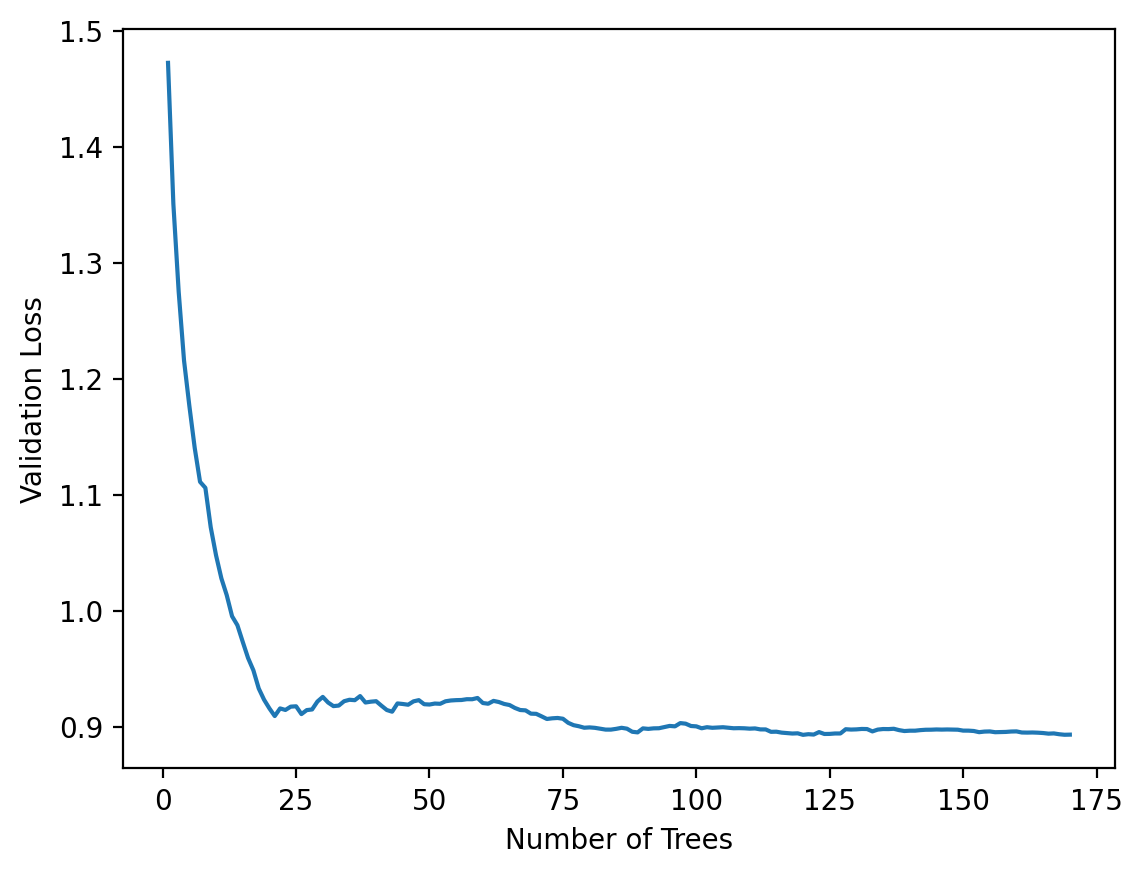

In [251]:

plot_tfdf_logs(inspector)

## Importances

In [252]:
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 NUM_NODES
	 INV_MEAN_MIN_DEPTH
	 SUM_SCORE
	 NUM_AS_ROOT


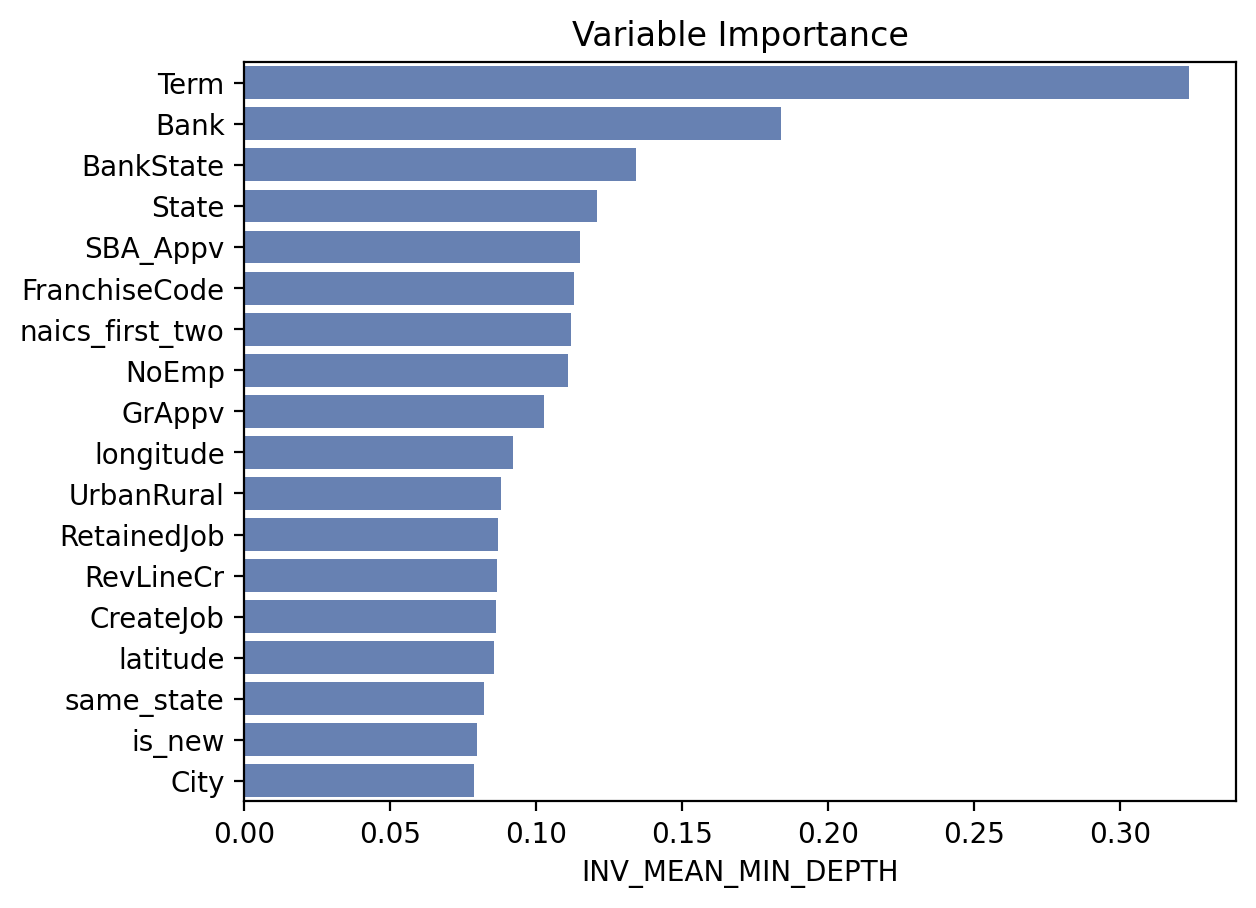

In [254]:
plot_tfdf_importances(inspector, 'INV_MEAN_MIN_DEPTH')

## Plot Indvidual Trees

In [255]:
first_tree = inspector.extract_tree(tree_idx=0)
print(first_tree.pretty())

(Term >= 59.5; miss=True, score=0.04190726578235626)
    ├─(pos)─ (naics_first_two in ['44', '72', '45', '56', '48', '71', '53', '51', '52', '61', '49']; miss=False, score=0.00032477438799105585)
    │        ├─(pos)─ (FranchiseCode in ['<OOD>', '0']; miss=False, score=0.0025796983391046524)
    │        │        ├─(pos)─ (BankState in ['CA', 'TX', 'FL', 'TN', 'WV']; miss=True, score=0.014457544311881065)
    │        │        │    ...
    │        │        └─(neg)─ (same_state >= 0.5; miss=True, score=0.00047992734471336007)
    │        │             ...
    │        └─(neg)─ (Term >= 82.5; miss=True, score=0.002290292177349329)
    │                 ├─(pos)─ (Bank in ['<OOD>', 'SUPERIOR FINANCIAL GROUP, LLC']; miss=False, score=0.0005160542204976082)
    │                 │    ...
    │                 └─(neg)─ (BankState in ['<OOD>', 'CA', 'NC', 'VA']; miss=True, score=0.014865127392113209)
    │                      ...
    └─(neg)─ (UrbanRural in ['1', '2']; miss=True, score=0.02

In [273]:
with open("plot.html", "w") as f: 
    f.write(tfdf.model_plotter.plot_model(manual_tuned, tree_idx=0, max_depth=4))

In [305]:
# Save the model
manual_tuned.save("../models/loan_default_model/1/")